In [74]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [75]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [76]:
len(words)

32033

In [77]:
# building the vocabulary of charcters and mappings to integers and integer to characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [78]:
block_size = 3 # context length from how man y words we predict the next one

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr,  ytr  = build_dataset(words[:n1])     # 80%
xdev, ydev = build_dataset(words[n1:n2])   # 10%
xte,  yte  = build_dataset(words[n2:])     #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [79]:

n_embd = 10 # the dimensionality of the character look up we can multiply it with block size
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5) #scaling factor for tanh is 5/3 and here divide with sqrt of fanin
b1 = torch.randn(n_hidden,                        generator=g)*0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g)*0.01 
b2 = torch.randn(vocab_size,                      generator=g)*0  # multiply with 0 to reduce the logits value closer to 0
bngain=torch.ones(1,n_hidden)
bnbias=torch.ones(1,n_hidden)
parameters = [C, W1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True #it keep tracks the gradient

12097


In [ ]:
# using xtr and ytr
max_steps=200000
batch_size=32 #using  minibatch
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator = g) #mini batch constructed
    xb,yb=xtr[ix],ytr[ix]
    emb=C[xb] #32,3,10
    embcat=emb.view(emb.shape[0],-1) #in -1 pytorch automatically assigns the value
    hpreact=embcat @ W1 + b1 #hidden layer pre activation
    hpreact=bngain*(hpreact-(hpreact.mean(0,keepdim=True)))/hpreact.std(0,keepdim=True)+bnbias #batch normalization layer
    h=torch.tanh( hpreact)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,yb)# loss function

    #backward pass
    for p in parameters:
         p.grad=None
    loss.backward()
    #update
    lr=0.1 if i<10000 else 0.01
    for p in parameters:
         p.data+=-lr*p.grad
    if i%10000==0:
         print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    


      0/ 200000:3.3401
  10000/ 200000:2.2846
  20000/ 200000:2.2960
  30000/ 200000:2.4360
  40000/ 200000:1.9294
  50000/ 200000:2.5728
  60000/ 200000:2.4117
  70000/ 200000:2.0715
  80000/ 200000:2.3679
  90000/ 200000:2.0385
 100000/ 200000:2.0463
 110000/ 200000:2.3346
 120000/ 200000:2.0218
 130000/ 200000:2.4903
 140000/ 200000:2.2162
 150000/ 200000:2.2647
 160000/ 200000:2.0479
 170000/ 200000:1.7791
 180000/ 200000:2.1367
 190000/ 200000:1.8638


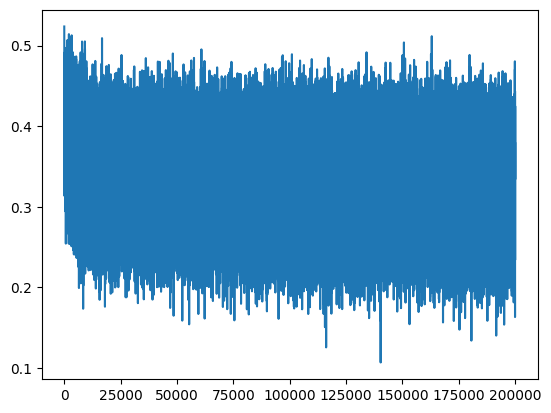

In [81]:
plt.plot(lossi)

In [82]:
logits[0]

tensor([-1.4647,  1.3669,  0.1131, -1.2610,  0.1603,  1.7054, -1.2947, -1.8033,
         0.3748,  1.9036, -1.8058, -1.6077,  2.1767,  1.4414,  3.2101,  1.3231,
         0.0992, -3.5926,  1.3728,  0.6475,  0.2178, -1.2061,  0.2501, -1.4723,
        -1.9743,  1.9536, -0.5836], grad_fn=<SelectBackward0>)

In [83]:
#Saturated-when the act func produces output very close to the input values
#non linearity is function where output change does not directly propotional to input
#when we use relu it destroys half in the negative site , to compensate this with a gain we use sd=sqrt(2/N_in)(using kaiming init techniq for weight adjustment)
#formula for weigt adjusment in tanh ==gain/sqrt(fanin)
#A Gaussian distribution with zero mean and controlled variance ensures weights stay in a balanced range.(for relu and tanh)
#in batch normalization reduce the loss by adjusting the mean and variance across a mini batch
#have a screenshot for formulas normalize the hidden hpreact layer using gaussian distribution

In [92]:
@torch.no_grad() #this disables gradient tracking
def split_loss(split):
    x,y={
    'train' : (xtr,ytr),
    'val' : (xdev,ydev),
    'test': (xte,yte),
    }[split] # it takes the train and val string in the list
    emb=C[x] #(N,blocksize,n_embd)
    embcat=emb.view(emb.shape[0],-1) #concat with (N,blocksize* n_embd)
    hpreact=embcat @ W1 + b1 #N,n_hidden 
    hpreact=bngain*(hpreact-(hpreact.mean(0,keepdim=True)))/hpreact.std(0,keepdim=True)+bnbias
    h=torch.tanh( hpreact)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,y)# loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.1122264862060547
val 2.143420934677124


In [85]:
# loss 
#  fix softmax confidently wrong---->
# train 2.1446988582611084
# val 2.1785755157470703
#fix tanh layer saturated at init------>
# train 2.100076198577881
# val 2.1391818523406982
#use semi principled kaiming init instead of hacky init(ie multiply the weight by gain divided by sqrt(fanin))
# train 2.0994210243225098
# val 2.1359660625457764
#Add a batch norm layer


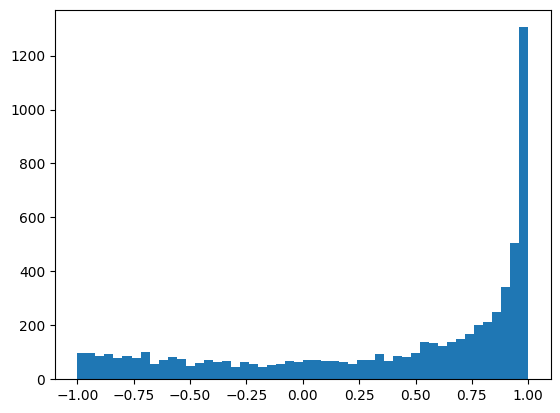

In [86]:
plt.hist(h.view(-1).tolist(),50); #tanh doesn't affect the loss because it is a flat surface(refer tanh backward in micrograd)

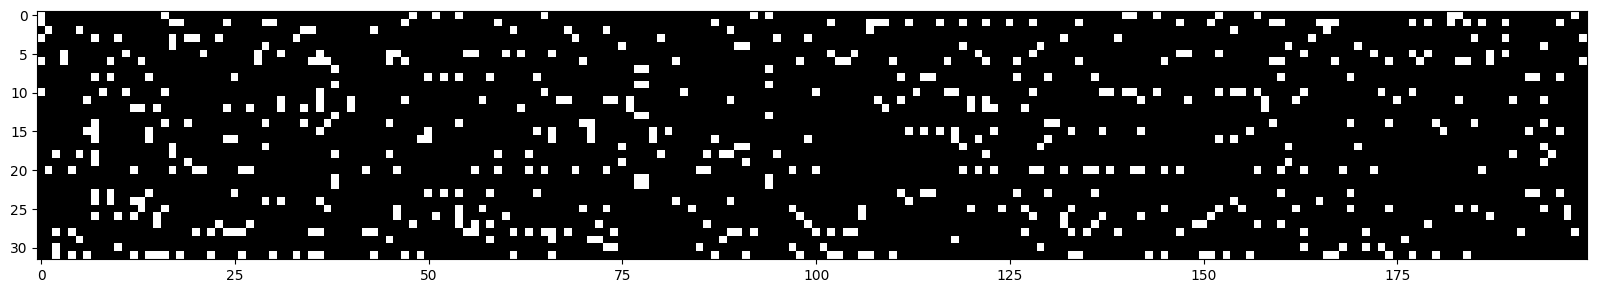

In [87]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='grey',interpolation='nearest')
#in 200 colums if one row is fully white (i.e) true is dead neuron and does not learn anything

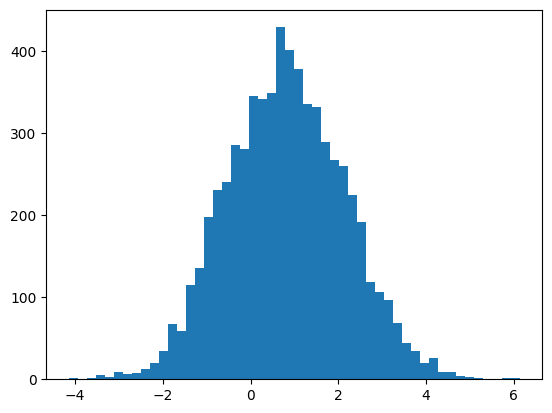

In [88]:
plt.hist(hpreact.view(-1).tolist(),50);

In [89]:
(torch.rand(1000)*0.2).std()

tensor(0.0576)

tensor(0.0084) tensor(1.0045)
tensor(0.0006) tensor(1.0010)


(array([1.99167663e-05, 0.00000000e+00, 0.00000000e+00, 1.99167663e-05,
        0.00000000e+00, 0.00000000e+00, 9.95838315e-05, 1.39417364e-04,
        1.99167663e-04, 4.58085625e-04, 7.17003587e-04, 1.51367424e-03,
        2.09126046e-03, 3.34601674e-03, 6.31361492e-03, 1.01774676e-02,
        1.67699172e-02, 2.70868022e-02, 4.56492284e-02, 7.22580281e-02,
        1.10717304e-01, 1.60768138e-01, 2.17072836e-01, 2.90286869e-01,
        3.53721769e-01, 4.03234850e-01, 4.26696801e-01, 4.14069571e-01,
        3.64436990e-01, 3.08670044e-01, 2.39837700e-01, 1.72519030e-01,
        1.19799349e-01, 8.12205730e-02, 5.12657564e-02, 3.41174207e-02,
        1.95184310e-02, 1.22288945e-02, 6.45303228e-03, 4.04310356e-03,
        2.64892992e-03, 1.37425687e-03, 8.16587418e-04, 5.17835924e-04,
        1.79250897e-04, 1.39417364e-04, 9.95838315e-05, 1.99167663e-05,
        0.00000000e+00, 1.99167663e-05]),
 array([-6.685534  , -6.43448923, -6.18344446, -5.93239969, -5.68135492,
        -5.43031015, 

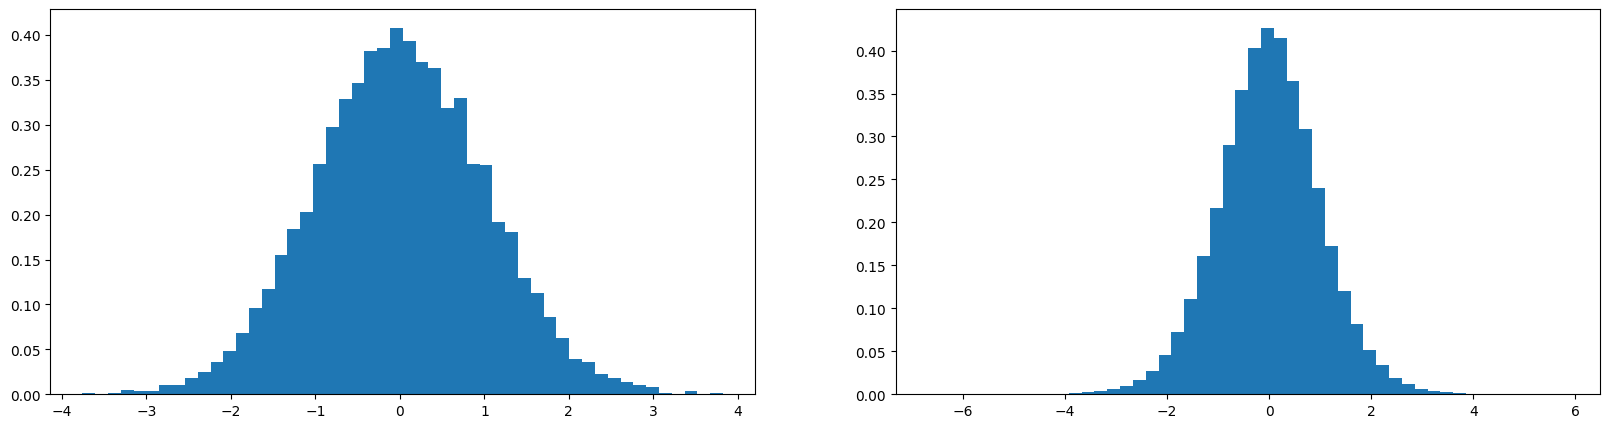

In [90]:
x=torch.randn(1000,10)
w=torch.randn(10,200) /10**0.5
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=[20,5])
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)
